In [3]:
import pandas as pd
import numpy as np
import re
import time
import datetime
import pickle
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import func 


In [4]:
#读取数据，查看数据基本情况
df = pd.read_csv('loan.csv')

c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [7]:
#剔除贷中数据和id,member_id
df = df.drop(['id', 'member_id', 'url','next_pymnt_d','last_pymnt_d','pymnt_plan','application_type',
             'last_credit_pull_d','title','sub_grade','total_rec_prncp','total_rec_int','out_prncp','policy_code',
             'last_pymnt_amnt','installment','total_pymnt_inv', 'total_rec_prncp','total_rec_int'], axis=1)


In [8]:
'''
df = df.dropna(subset=['issue_d', 'earliest_cr_line'])
df.drop([484446,531886],inplace=True)

'''


In [9]:
#数据预处理


#处理term，去除months转化为数值

df['term'] = df['term'].apply(lambda x: int(x.replace('months' , '')))
df = df.loc[df.term == 36]

#处理目标值loan_status，将Charged Off 和Late (31-120 days)归为逾期，列为1
df['y'] = df['loan_status'].map(lambda x : int((x=='Charged Off') | (x == 'Late (31-120 days)')))

#处理工作时间emp_length
def workYear(x):
    x = str(x)
    if x.find('n/a')>-1:
        return -1
    elif x.find('<1')>-1 :
        return 0
    elif x.find("10+") >-1:
        return 11
    else :
        return int(re.sub("\D", "", x))

df['emp_length'] = df['emp_length'].map(workYear)

#将desc缺失作为一种状态，非缺失作为一种
def Desc(x):
    if type(x).__name__ == 'float':
        return 'no desc'
    else:
        return 'desc'

df['desc'] = df['desc'].map(Desc)

#处理时间,earliest_cr_line（第一次借贷时间）和issue_d（申请时间）

def ConvertDate(x):

    mth_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10,
                'Nov': 11, 'Dec': 12}
    yr = int(x[4:6])
    mth = mth_dict[x[:3]]
    return datetime.datetime(yr, mth, 1)
df['issue_d'] = df['issue_d'].map(lambda x :ConvertDate(x))
df['earliest_cr_line'] = df['earliest_cr_line'].map(lambda x: ConvertDate(x))

#处理mths_since_last_delinq，用-1代替缺失值，有值用0

def missing(x):
    if np.isnan(x):
        return -1
    else:
        return x
    
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].map(lambda x: missing(x))
df['mths_since_last_record'] = df['mths_since_last_record'].map(lambda x: missing(x))
#df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].map(lambda x: missing(x))      
        


In [10]:
df.describe(include=['O']).T.assign(missing_percent = df.apply(lambda x : (len(x) - x.count())/len(x)))

,count,unique,top,freq,missing_percent
grade,621094,7,B,211999,0.000000
emp_title,579516,225375,Teacher,9071,0.066943
home_ownership,621094,6,MORTGAGE,288371,0.000000
verification_status,621094,3,Not Verified,222816,0.000000
issue_d,621094,12,0020-10-01 00:00:00,77932,0.000000
loan_status,621094,10,Current,402846,0.000000
desc,621094,2,no desc,524071,0.000000
purpose,621094,14,debt_consolidation,351846,0.000000
zip_code,621094,920,945xx,7165,0.000000
addr_state,621094,51,CA,96191,0.000000


In [11]:
a = df.describe().T.assign(missing_percent = df.apply(lambda x : (len(x) - x.count())/len(x)))


In [15]:

#删除缺失值大于97%的变量
df.dropna(thresh=len(data) *0.03, axis=1, inplace=True)

In [16]:
#衍生变量

#申请金额与收入的占比
df['limit_income'] = df.apply(lambda x:x.loan_amnt /x.annual_inc, axis=1)

#申请时间和第一次贷款时间之前的差值
def MonthGap(earlyDate, lateDate):
    if lateDate > earlyDate:
        gap = relativedelta(lateDate, earlyDate)
        yr = gap.years
        mth = gap.months
        return yr*12 + mth
    else:
        return 0
df['earliest_cr_to_app'] = df.apply(lambda x : MonthGap(x.earliest_cr_line, x.issue_d),axis=1)

In [17]:
df = df.drop(['mths_since_last_record','mths_since_last_major_derog',
'mths_since_last_delinq','emp_title'], axis=1)


In [18]:
#t替换缺失值
for col in ['total_rev_hi_lim' ,'tot_cur_bal','tot_coll_amt','collections_12_mths_ex_med', 'revol_util']:
    df[col] = df[col].map(lambda x : missing(x))

In [19]:
#将字符型的数据转化为数值型，因为评分卡要WOE转化不用进行归一化或独热编码
map_list = {'grade' : {"A": 0,"B": 1,"C": 2, "D": 3, "E": 4,"F": 5,"G": 6},
           "verification_status":
                   {"Not Verified":0,"Source Verified":1,"Verified":2},
               "purpose":
                   {"credit_card":0,"home_improvement":1,"debt_consolidation":2,       
                    "other":3,"major_purchase":4,"medical":5,"small_business":6,
                    "car":7,"vacation":8,"moving":9, "house":10, 
                    "renewable_energy":11,"wedding":12},
               "home_ownership":
                   {"MORTGAGE":0,"ANY":1,"NONE":2,"OWN":3,"RENT":4},
           "initial_list_status": 
                   {"w": 0,"f": 1,}}
df = df.replace(map_list)

In [20]:
df = df.drop('term', axis=1)

In [21]:

total = df.groupby(['addr_state'])['y'].count()
total = pd.DataFrame({"total" : total})
bad = df.groupby(['addr_state'])['y'].sum()
bad = pd.DataFrame({"bad" : bad})
regroup = total.merge(bad, left_index=True, right_index=True,how="left")
regroup.reset_index(level=0, inplace=True)
regroup['bad_rate'] = regroup.apply(lambda x :x.bad *1.0 /x.total, axis=1)#加上一列坏样本率
dicts = dict(zip(regroup['addr_state'], regroup['bad_rate']))#每箱对应的坏样本率组成的字典

N = sum(regroup['total'])
B = sum(regroup['bad'])
overallRate = B*1.0/N

In [22]:
'''
#分箱，采用ChiMerge，要求分箱完之后：
(1)不超过5箱
（2）每箱同时包含好坏样本
（3）特殊值，如-1单独成一箱
连续型变量可以直接分箱
类别型变量：
（1）当取值较多的时候，先用bad_rate编码，再用连续型分箱的方式进行分箱
（2）当取值较少时，如果每种类别同时包含好坏样本，则无需分箱，如果有类别只包含好坏样本的一种，需要合并

'''


cat_features =['home_ownership', 'desc', 'purpose', 'zip_code', 'addr_state']
num_features = df.dtypes[df.dtypes != 'object'].index.tolist()
num_features.pop(-3)

more_value_features = []
less_value_features = []
#第一步，检查类别型变量中，哪些变量取值超过5
for var in cat_features:
    valueCounts = len(set(df[var]))
    print(valueCounts)
    if valueCounts >5:
        more_value_features.append(var)#取值大于5的，需要bad_rate进行编码，然后运用卡方分箱
    else:
        less_value_features.append(var)
        #取值小于5的，如果每种类别同时包含好坏样本，无需分箱，如果有类别只包含好坏一种，需要合并
merge_bin_dict = {}#存放需要合并的变量以及合并方法
var_bin_list = [] #由于某个取值没有好或坏样本而需要合并
for col in less_value_features:
    binBadRate = func.BinBadRate(df, col, 'y')[0]
    if min(binBadRate.values() ) == 0:
        print('{} need to  be combined due to 0 bad rate'.format(col))
        combine_bin = func.MergeBad0(df, col, y)
        merge_bin_dict[col] = combine_bin
        newVar = col +'_Bin'
        df[newVar] = df[col].map(combine_bin)
        var_bin_list.append(newVar)
    if max(binBadRate.values()) == 1:
        print('{} need to be combined due to 1 bad rate'.format(col))
        combine_bin = func.MergeBad0(df, col, y)
        merge_bin_dict[col] = combine_bin
        newVar = col + '_Bin'
        df[newVar] = df[col].map(combine_bin)
        var_bin_list.append(newVar)
    
#less_value_features里剩下不需要合并的变量
less_value_features = [i for i in less_value_features if i + '_Bin' not in var_bin_list]
less_value_features.append('verification_status')
less_value_features.append('initial_list_status')

6
2
14
920
51


In [23]:
br_encoding_dict = {} #记录按照bad_rate进行编码的变量及编码方式
for col in more_value_features:
    br_encoding = func.BadRateEncoding(df, col, 'y')
    df[col+'br_encoding'] = br_encoding['encoding']
    br_encoding_dict[col] = br_encoding['bad_rate']
    num_features.append(col + 'br_encoding')

In [24]:
num_features.pop(7)



'verification_status'

In [25]:
num_features.pop(15)

'initial_list_status'

In [26]:
num_features.pop(-10)

'acc_now_delinq'

In [27]:


for var in num_features:  
    valueCounts = len(set(df[var]))
    print(var ,valueCounts)

loan_amnt 1371
funded_amnt 1371
funded_amnt_inv 7724
int_rate 528
grade 7
emp_length 11
annual_inc 37212
dti 4034
delinq_2yrs 26
inq_last_6mths 28
open_acc 71
pub_rec 29
revol_bal 63902
revol_util 1287
total_acc 125
out_prncp_inv 168469
total_pymnt 366498
total_rec_late_fee 4500
recoveries 14839
collection_recovery_fee 13164
collections_12_mths_ex_med 12
tot_coll_amt 8948
tot_cur_bal 258784
total_rev_hi_lim 16419
limit_income 88870
earliest_cr_to_app 24
home_ownershipbr_encoding 6
purposebr_encoding 14
zip_codebr_encoding 722
addr_statebr_encoding 51


In [28]:
#对连续型变量进行分箱，包括已经bad_rate编码后的类别型变量
#from imp import reload
#reload(func)
continous_merged_dict = {}

for col in num_features:
    print("{} is in processing".format(col))
    if -1 not in set(df[col]): #-1当成特殊值处理
        max_interval = 5
        cutoff = func.chiMerge(df, col, 'y',max_interval = max_interval,
                          special_attribute=[],minBinPcnt=0)
        df[col + '_Bin'] = df[col].map(lambda x : func.AssignBin(x, cutoff, special_attribute=[]))
        monotone = func.BadRateMonotone(df, col+'_Bin','y' )
        while (not monotone):
            #检验分箱后的单调性是否满足，如果不满足则缩减分箱的个数
            max_interval -= 1
            cutoff = func.chiMerge(df, col ,'y',max_interval = max_interval,
                                  special_attribute =[], minBinPcnt=0)
            df[col + '_Bin'] = df[col].map(lambda x : func.AssignBin(x, cutoff, special_attribute=[]))
            if max_interval == 2:
                #当分箱数为2时，必然单调
                break
            monotone = func.BadRateMonotone(df, col+'_Bin', 'y')
        newVar = col + '_Bin'
        df[newVar] = df[col].map(lambda x: func.AssignBin(x, cutoff,special_attribute=[]))
        var_bin_list.append(newVar)
        
    else:
        max_interval = 5
        #如果有-1，则除去-1后，其他取值参与分箱
        cutoff = func.chiMerge(df, col, 'y', max_interval=max_interval,
                                  special_attribute =[-1], minBinPcnt=0)
        df[col + '_Bin'] = df[col].map(lambda x : func.AssignBin(x, cutoff, special_attribute=[-1]))
        monotone = func.BadRateMonotone(df, col+'_Bin', 'y',['Bin -1'])
        while (not monotone):
            max_interval -=1
            #如果有-1，-1的bad_rate不参与单调性检验
            cutoff = func.chiMerge(df, col,'y', max_interval=max_interval, 
                                  special_attribute=[-1], minBinPcnt=0)
            df[col + '_Bin'] = df[col].map(lambda x : func.AssignBin(x, cutoff,
                                                                    special_attribute=[-1]))
            if max_interval == 3:
                break
            monotone = func.BadRateMonotone(df, col+'_Bin', 'y')
        newVar = col + '_Bin'
        df[newVar] = df[col].map(lambda x : func.AssignBin(x, cutoff, special_attribute=[-1]))
        var_bin_list.append(newVar)
    continous_merged_dict[col] = cutoff
            
        

loan_amnt is in processing
funded_amnt is in processing
funded_amnt_inv is in processing
int_rate is in processing
grade is in processing
emp_length is in processing


E:\py\评分卡\func.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['temp'] = df2[col]
E:\py\评分卡\func.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['temp_Bin'] = groupedvalues


annual_inc is in processing
dti is in processing
delinq_2yrs is in processing
inq_last_6mths is in processing
open_acc is in processing
pub_rec is in processing
revol_bal is in processing
revol_util is in processing


E:\py\评分卡\func.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['temp'] = df2[col].map(lambda x: AssignGroup(x, split_x))


total_acc is in processing
out_prncp_inv is in processing
total_pymnt is in processing
total_rec_late_fee is in processing
recoveries is in processing
collection_recovery_fee is in processing
collections_12_mths_ex_med is in processing
tot_coll_amt is in processing
tot_cur_bal is in processing
total_rev_hi_lim is in processing
limit_income is in processing
earliest_cr_to_app is in processing
home_ownershipbr_encoding is in processing
purposebr_encoding is in processing
zip_codebr_encoding is in processing
addr_statebr_encoding is in processing


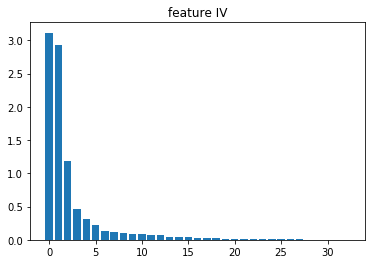

In [29]:
#WOE编码，计算IV
from imp import reload
reload(func)
WOE_dict = {}
IV_dict = {}
#分箱后的变量进行编码，分别存储在less_value_features和var_bin_list中
all_var = var_bin_list + less_value_features
for var in all_var:
    woe_iv = func.CalcWOE(df, var, 'y')
    WOE_dict[var] = woe_iv['WOE']
    IV_dict[var] = woe_iv['IV']

    
#将变量IV值进行降序排列，方便后续挑选变量
IV_dict_sorted = sorted(IV_dict.items(), key=lambda x :x[1],reverse=True)

IV_values = [i[1] for i in IV_dict_sorted]
IV_name = [i[0] for i in IV_dict_sorted]
plt.title('feature IV')
plt.bar(range(len(IV_values)), IV_values)
plt.show()

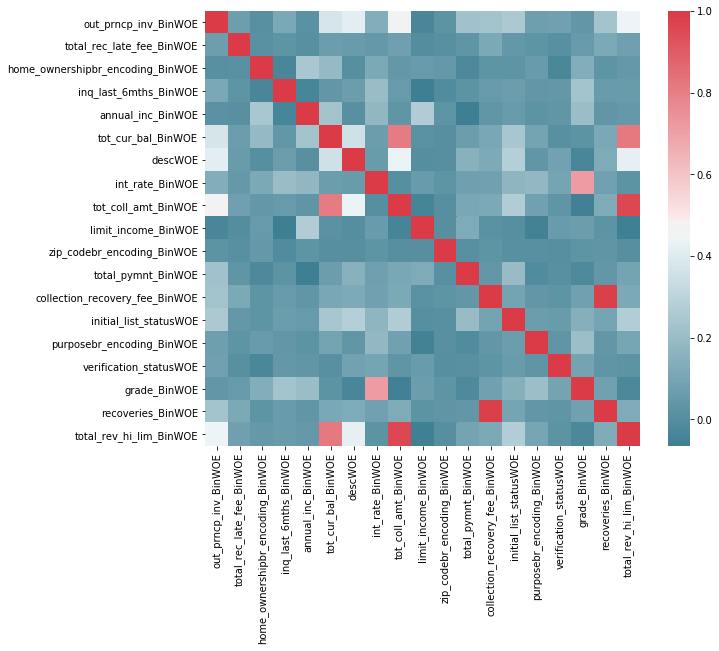

In [30]:
#单变量分析和多变量分析，均基于WOE编码后的值
#（1）选择IV值高于0.01的变量
#（2）比较两两线性相关性，如果相关系数的绝对值高于阈值，剔除IV较低的一个

#选取IV>0.02的变量
high_IV = {k : v for k, v in IV_dict.items() if v >=0.02}
high_IV_sorted = sorted(high_IV.items(), key=lambda x : x[1], reverse=True)

short_list = high_IV.keys()
short_list_2 = []

for var in short_list:
    newVar = var + 'WOE'
    df[newVar] = df[var].map(WOE_dict[var])
    short_list_2.append(newVar)
    

#对于上一步的结果，计算相关系数矩阵，并画出热力图进行数据可视化
dfWOE = df[short_list_2]
f, ax = plt.subplots(figsize=(10,8))
corr = dfWOE.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220,10,as_cmap=True),square=True, ax=ax)

    
plt.show()


In [31]:
#两两间的线性相关性检验
#1.将候选变量按照IV进行降序排列
#2.计算第i和第i+1的变量的线性相关系数
#3.对于系数超过阈值的两个变量，剔除IV较低的一个
deleted_index = []
cnt_vars = len(high_IV_sorted)
for i in range(cnt_vars):
    if i in deleted_index:
        continue
    x1 = high_IV_sorted[i][0] + "WOE"
    for j in range(cnt_vars):
        if i == j or j in deleted_index:
            continue
        y1 = high_IV_sorted[j][0] + "WOE"
        roh = np.corrcoef(df[x1],df[y1])[0, 1]
        if abs(roh) >0.7:
            x1_IV = high_IV_sorted[i][1]
            y1_IV = high_IV_sorted[j][1]
            if x1_IV > y1_IV:
                deleted_index.append(j)
            else:
                deleted_index.append(i)
                
multi_analysis_vars_1 = [high_IV_sorted[i][0] + "WOE" for i in range(cnt_vars) if i not in deleted_index]

In [49]:
#多变量分析
#VIF方差扩大因子，是指解释变量之间存在多重共线性时的方差与不存在多重共线性时的方差之比
#VIF越大，显示共线性越严重，0<VIF<10,不存在共线性，10=<VIF<100，存在较强多重共线性,VIF>=100，存在严重多重共线性
from statsmodels.stats.outliers_influence import variance_inflation_factor
x = np.matrix(df[multi_analysis_vars_1])
VIF_list = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
max_VIF = max(VIF_list)
print(max_VIF)
#不存在多重共线性
multi_analysis = multi_analysis_vars_1

1.5830798895038285


In [33]:
#逻辑回归
#要求变量显著，符号为负

#将多重变量分析后的变量带入到LR模型中
from sklearn.model_selection import train_test_split
traindata, testdata = train_test_split(df, test_size=0.3)
train_x = traindata[multi_analysis]
test_x = testdata[multi_analysis]
train_y = traindata['y']
test_y = testdata['y']
train_x['intercept'] = [1] * train_x.shape[0]


c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [50]:
LR = sm.Logit(train_y, train_x).fit()
summary = LR.summary()
print(summary)
pvals = LR.pvalues
pvals = pvals.to_dict()
print(pvals)


Optimization terminated successfully.
         Current function value: 0.128386
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               434765
Model:                          Logit   Df Residuals:                   434750
Method:                           MLE   Df Model:                           14
Date:                Mon, 11 Jun 2018   Pseudo R-squ.:                  0.4208
Time:                        10:30:33   Log-Likelihood:                -55818.
converged:                       True   LL-Null:                       -96363.
                                        LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
recoveries_BinWOE                   -0.9174      0.010    -94.31

In [39]:
pvals.items()

dict_items([('tot_cur_bal_BinWOE', 7.638793830145418e-139), ('descWOE', 2.37048786185504e-34), ('total_rec_late_fee_BinWOE', 0.0), ('inq_last_6mths_BinWOE', 3.211221775202698e-12), ('zip_codebr_encoding_BinWOE', 1.4133154253333819e-95), ('initial_list_statusWOE', 8.621454579224229e-05), ('out_prncp_inv_BinWOE', 0.0), ('intercept', 0.0), ('home_ownershipbr_encoding_BinWOE', 6.794556818002352e-21), ('limit_income_BinWOE', 6.697258856892381e-72), ('purposebr_encoding_BinWOE', 0.006381994048566539), ('verification_statusWOE', 0.11041895241255566), ('int_rate_BinWOE', 0.0), ('recoveries_BinWOE', 0.0), ('total_pymnt_BinWOE', 6.3807996947577796e-55), ('annual_inc_BinWOE', 7.814466798151997e-74)])

In [67]:
from imp import reload
reload(func)
summary = LR.summary()
traindata['prob'] = LR.predict(train_x)
ks = func.KS(traindata, 'prob', 'y')
auc = roc_auc_score(traindata['y'], traindata['prob'])
print('normalLR : ks {}, auc {}'.format(ks, auc))

c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


normalLR : ks 0.5981498229673522, auc 0.875277646353698
